In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the ticker symbol for S&P 500
ticker_symbol = "^GSPC"

# Set the end date to today
end_date = datetime.today().strftime('%Y-%m-%d')

# Set the start date to one year ago from today
start_date = (datetime.today() - timedelta(weeks=1000)).strftime('%Y-%m-%d') ## worked with 365 days

# Fetch historical data from Yahoo Finance
# sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date).pct_change().fillna(0)
sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [3]:
def smoothing(kernel_size,data):
  kernel = np.ones(kernel_size) / kernel_size
  return np.convolve(data, kernel, mode='same')

4823


(array([12418., 13879., 15340., 16801., 18262., 19723., 21184.]),
 [Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024'),
  Text(21184.0, 0, '2028')])

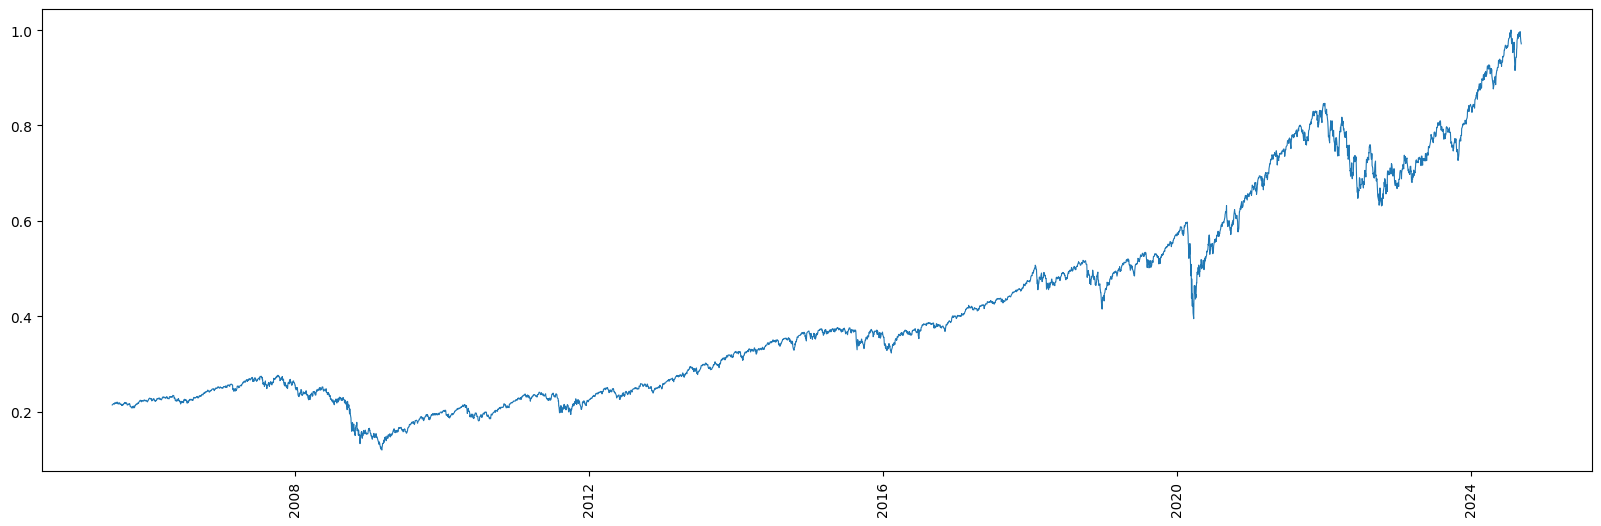

In [4]:
dates_list = sp500_data.index.tolist()
close_prices_list = sp500_data['Close'].tolist()

# plt.plot(sp500_data.index,close_prices_list, linewidth = 0.8)
# plt.plot(sp500_data.index,smoothing(100,close_prices_list), linewidth = 0.8)
# plt.xticks(rotation=90)

## dataset creation
n = len(dates_list)
print(n)
fig = plt.figure(figsize =(20,6))
x, y = np.linspace(0.0, n/10,n), close_prices_list/np.max(close_prices_list)
# x, y = np.linspace(0.0, n/10,n), np.nan_to_num(sp500_data['Close'].pct_change().tolist())
plt.plot(sp500_data.index, y, linewidth = 0.8)
plt.xticks(rotation=90)

In [5]:
#### data set 2: (n+1)th pt given n first points in a time series.

def make_next_data(time_series,n, ndata, dn=1): ### OBSOLETE now
  '''times_series is a np 1D array, n-1 number of input points, dn space between them? Produces dataset with length ndata.'''
  l = len(time_series)-dn*n
  return np.array([[time_series[i*(l//ndata)+j*dn] for j in range(n)] for i in range(ndata)])

def make_next_data2(time_series,n, ndata, dn=1):
  '''times_series is a np 1D array, n-1 number of input points, dn space between them? Produces dataset with length ndata.
  For each window of input+output, substract the value before to normalise the data. first returned array is to get back the original normalisation later.'''
  # l = len(time_series)-dn*n-1
  # return np.array([[time_series[1+i*(l//ndata)+j*dn-1] for j in range(n)] for i in range(ndata)]), np.array([[time_series[1+i*(l//ndata)+j*dn]-time_series[1+i*(l//ndata)+j*dn-1] for j in range(n)] for i in range(ndata)])
  l = len(time_series)-dn*n-dn
  return np.array([[time_series[dn+i*(l//ndata)+j*dn-dn] for j in range(n)] for i in range(ndata)]), np.array([[time_series[dn+i*(l//ndata)+j*dn]-time_series[dn+i*(l//ndata)+j*dn-dn] for j in range(n)] for i in range(ndata)])

n = 10 ##>=2
recover_data, data2 = make_next_data2(y,n,1000,1)
x2, y2 = data2[:,:-1], data2[:,-1]
recover_x2, recover_y2 = recover_data[:,:-1], recover_data[:,-1]

## It seems to get worse when increasing dn (that might be different with a different asset trend...)
## changing n doesn't seem to change much (might change with multiple assests...)

# Normal NN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=.25, shuffle=False)

X2 = torch.tensor(X_train, dtype=torch.float32)
Y2 = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X2_test = torch.tensor(X_test, dtype=torch.float32)
Y2_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# define the model
n_per_layer = 5 # times input size
n_hidden_layers = 5

######## NN ##########
layers = []
layers.append(nn.Linear(n-1, n_per_layer*n))
layers.append(nn.ReLU())
for i in range(n_hidden_layers):
    layers.append(nn.Linear(n_per_layer*n, n_per_layer*n))
    layers.append(nn.ReLU())
layers.append(nn.Linear(n_per_layer*n, 1))
layers.append(nn.Sigmoid())
model = nn.Sequential(*layers)
print(model)
#####################


# train the model
loss_fn   = nn.MSELoss() # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 100

for epoch in range(n_epochs):
    for i in range(0, len(X2), batch_size):
        Xbatch = X2[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y2[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print(f'Finished epoch {epoch}, latest loss {loss}')

# compute accuracy (no_grad is optional)
#
#     y_pred = model(X2)
with torch.no_grad():
  Y2_pred = model(X2_test)
  Y2_pred_training = model(X2)


Sequential(
  (0): Linear(in_features=9, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): ReLU()
  (12): Linear(in_features=50, out_features=1, bias=True)
  (13): Sigmoid()
)


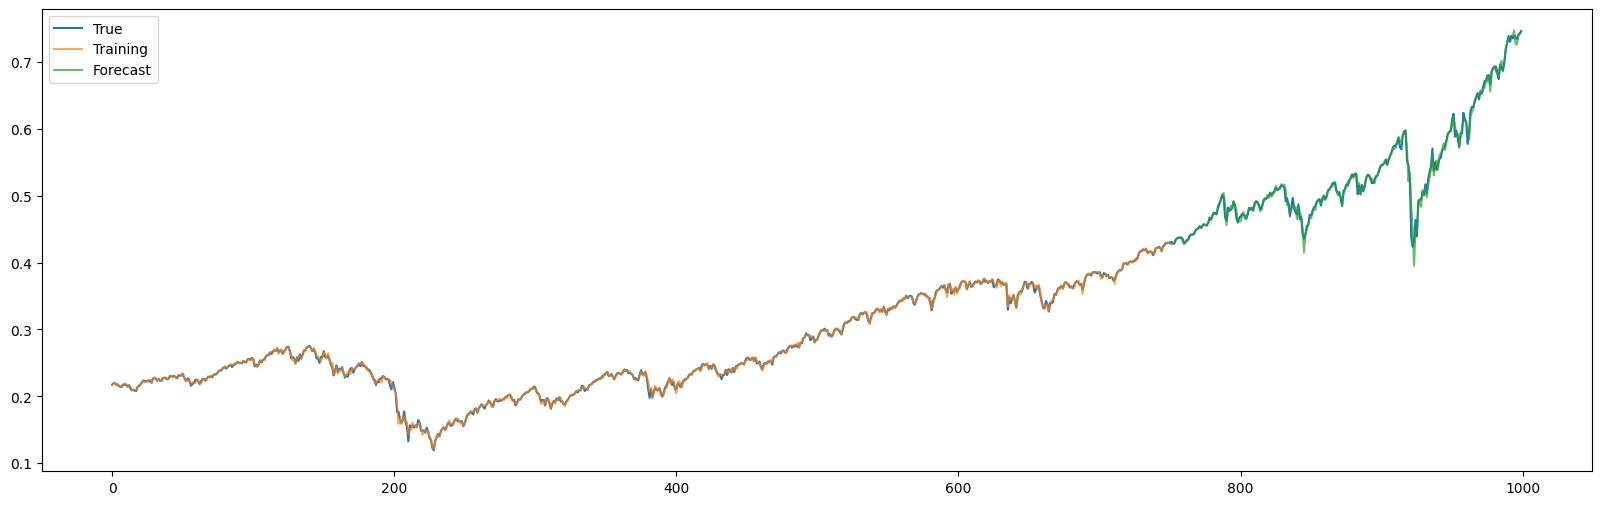

In [7]:
fig = plt.figure(figsize=(20,6))
# plt.plot(y2)
full_y_series = recover_y2+y2
plt.plot(full_y_series)
recover_X_train, recover_X_test, recover_y_train, recover_y_test = train_test_split(recover_x2, recover_y2, test_size=.25, shuffle=False)
full_trained_series = recover_y_train+ np.ravel(Y2_pred_training.numpy())
plt.plot(full_trained_series,alpha = 0.7)
full_pred_series = recover_y_test+np.ravel(Y2_pred.numpy())
n1,n2 = len(y2), len(Y2_pred_training)
plt.plot(range(n2,n1),full_pred_series,alpha = 0.7)
plt.legend(['True','Training','Forecast'])

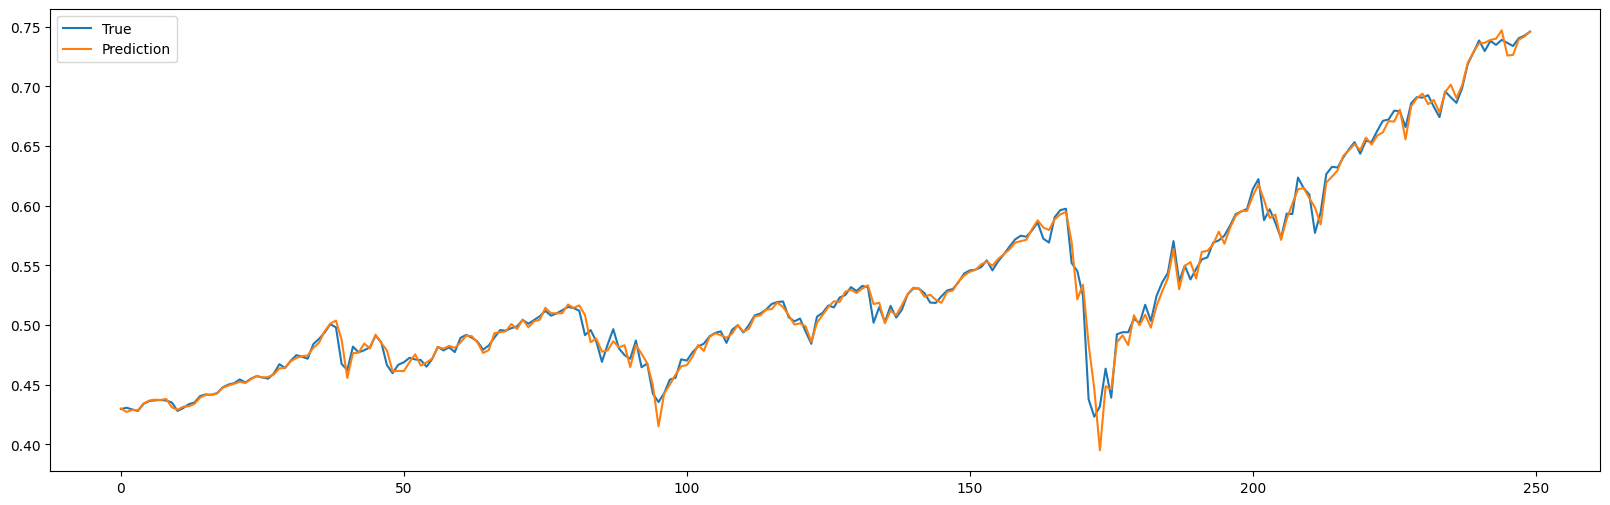

In [8]:
fig = plt.figure(figsize=(20,6))
full_test_true_y_series = recover_y_test+np.ravel(Y2_test.numpy())
plt.plot(full_test_true_y_series)
plt.plot(full_pred_series)
plt.legend(['True','Prediction'])

Text(0, 0.5, 'Cumulative returns (%)')

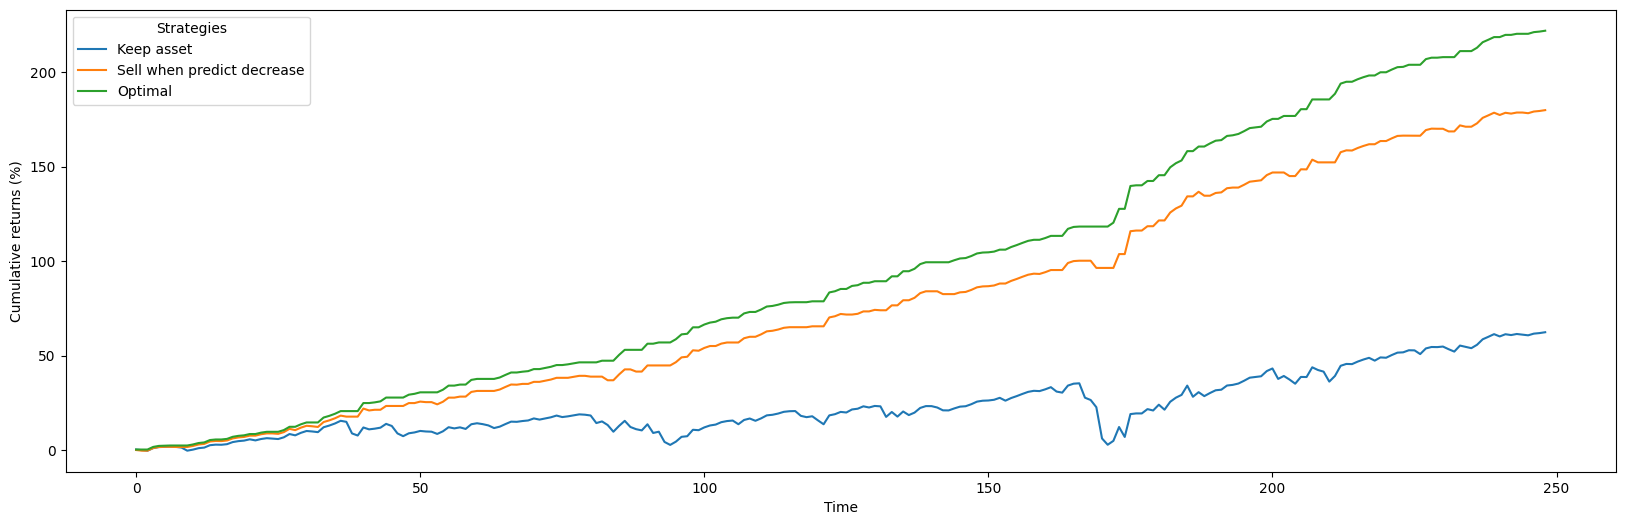

In [9]:
#### Return of the asset vs return on-off if up or down prediction.

# Calculate percentage change
def pctc(arr):
  return np.diff(arr) / arr[:-1] * 100

PCa = pctc(full_test_true_y_series)
PCb = np.copy(PCa)
PCmax = np.copy(PCa)

temp = pctc(full_pred_series)
PCb[temp<=0] = 0 # our prediction might tell us when to sell/buy (each time there is a increase/decrease pred)
PCmax[PCa<=0] =0 # can't get more returns than when knowing the real time-series values and selling when decrease incoming.

# cumulate the pct changes
PCa = PCa.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()

# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCa)
plt.plot(PCb)
plt.plot(PCmax)
plt.legend(['Keep asset', 'Sell when predict decrease','Optimal'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')

#BNN - obsolete for now

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

We can define a deep Bayesian neural network in a similar fashion, with Gaussian priors on the weights:

$p(\theta) = \mathcal{N}(\mathbf{0}, 5\cdot\mathbb{I})$.

The likelihood function is also Gaussian:

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)$, with $\sigma \sim \Gamma(0.5,1)$.

Here, $y_i$ represents the actual output for the $i$-th data point, $x_i$ represents the input for that data point, $\sigma$ is the standard deviation parameter for the normal distribution and $NN_{\theta}$ is the shallow neural network parameterized by $\theta$.

Note that we use $\sigma^2$ instead of $\sigma$ in the likelihood function because we use a Gaussian prior on $\sigma$ when performing variational inference and then want to avoid negative values for the standard deviation.

In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, n_hid_layers=2, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [ ]:
from pyro.infer import MCMC, NUTS

model = BNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

stop_training_time = int(0.80*n)
# Convert data to PyTorch tensors
x_train = torch.from_numpy(x[:stop_training_time]).float()
y_train = torch.from_numpy(y[:stop_training_time]).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [08:04,  4.85s/it, step size=1.01e-03, acc. prob=0.957]


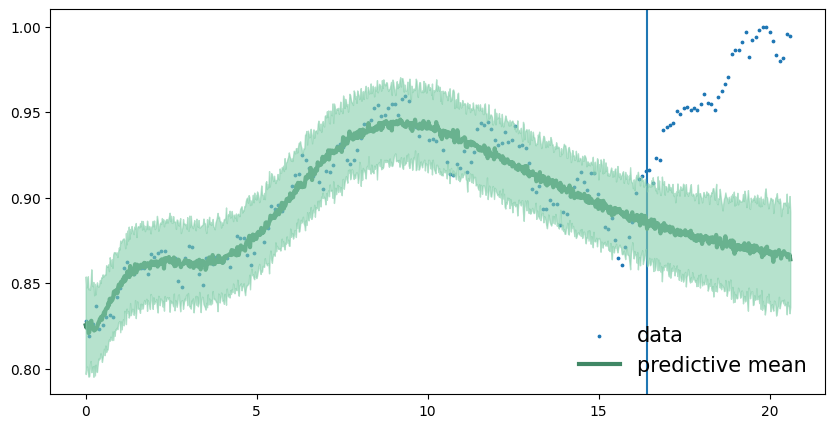

In [ ]:
from pyro.infer import Predictive
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(0,np.max(x),1000)
preds = predictive(x_test)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x, y, s=3, label="data")
ax.axvline(stop_training_time/10)
ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False)